In [1]:
import sys, h5py, pdb,time, glob,os 
from importlib import reload
import pylab as pl, numpy as np
from numpy import log10 as log
from astropy import units as un, constants as cons
import scipy, scipy.stats
from matplotlib import ticker, patches
from mpl_toolkits.mplot3d import Axes3D
sys.path.append('../../pysrc')

In [2]:
import workdirs as wd
import FIRE_files as ff
from FIRE_files import cosmo, u
from projectPlotBasics import *
import first_pass as l
cmap = pl.get_cmap('viridis')
figdir = wd.basedir+'ipynb/subsonic_solution/figures/'

Behroozi+18 not loaded
palettable colormaps are not installed
don't have phil's colormaps


In [3]:
CF_path = '../../../cooling_flow/pysrc'
sys.path.append(CF_path)
import cooling_flow as CF, HaloPotential as Halo
%matplotlib inline

In [4]:
vc = 200. *un.km/un.s
#simname = 'vc200_Rs0_Mdot4847_Rcirc10_fgas02_res1e4_n10_NoLowCool_tracking'
#Rcirc = 10.*un.kpc
#Nsnapshots,dt,rmax = 225,10,40
simname = 'vc200_Rs0_Mdot1035_Rcirc15_fgas02_res1e3'
Rcirc = 15.*un.kpc
Nsnapshots,dt,rmax = 45,50,40
simdir = wd.simdir+'/%s/output/'%simname
ts = -np.arange(Nsnapshots)*dt
ts = ts-ts[-1]

# for creation of tracks, skip afterward

In [5]:
#coords,vs,Ts,nHs,tcools = np.zeros((Nsnapshots,0,3)), np.zeros((Nsnapshots,0,3)), np.zeros((Nsnapshots,0)), np.zeros((Nsnapshots,0)), np.zeros((Nsnapshots,0))
#for lastSnapshot in range(50,60):#range(275,326):
#    npz_fn = wd.tracksdir+simname+'/particle_tracks_%d_%d_%d_%d.npz'%(Nsnapshots*5,dt,rmax,lastSnapshot)
#    #snapNumbers = range(lastSnapshot-Nsnapshots,lastSnapshot,1)
#    
#    if os.path.exists(npz_fn):
#        f = np.load(npz_fn)
#    else:
#        print(npz_fn)
#        continue
#    coords = np.concatenate([coords,f['coords']],axis=1)
#    print(lastSnapshot, coords.shape)
#    vs = np.concatenate([vs,f['vs']],axis=1)
#    Ts = np.concatenate([Ts,f['Ts']],axis=1)
#    nHs = np.concatenate([nHs,f['nHs']],axis=1)
#    tcools = np.concatenate([tcools,f['tcools']],axis=1)
#    f.close()

In [6]:
#npz_fn = wd.tracksdir+simname+'/particle_tracks_%d_%d_%d_all.npz'%(Nsnapshots,dt,rmax)
#np.savez(npz_fn,coords=coords[:,::50,...],vs=vs[:,::50,...],Ts=Ts[:,::50,...],nHs=nHs[:,::50,...],tcools=tcools[:,::10,...])

In [7]:
npz_fn = wd.tracksdir+simname+'/particle_tracks_%d_%d_%d_all.npz'%(Nsnapshots,dt,rmax)
f = np.load(npz_fn)
coords,vs,Ts,nHs,tcools=f['coords'],f['vs'],f['Ts'],f['nHs'],f['tcools'][:,::,...]

In [8]:
isStar = np.isnan(Ts[:,:])
tSF_ind  = np.array([np.concatenate([np.array([True]), isStar[:,i]]).nonzero()[0][-1] for i in range(isStar.shape[1])])
tSF = ts[tSF_ind]
isCool = Ts[:,:]<1e5
t105_ind = np.array([np.concatenate([np.array([True]), isCool[:,i]]).nonzero()[0][-1] for i in range(isCool.shape[1])])
t105= ts[t105_ind]

In [9]:
mu = 0.62
epsilons = Ts / (un.km**2/un.s**2 * cons.m_p / cons.k_B).to('K').value / (2./3* mu) 
cs = (epsilons*10/9)**0.5 
nHTs = nHs*Ts
Ks = (cons.k_B*Ts*un.K/(nHs*un.cm**-3)**(2/3.)).to('keV*cm**2').value

In [10]:
rhos = nHs*cons.m_p.to('g')/ff.X

In [11]:
Edots = epsilons * (un.km**2/un.s**2).to('erg*g**-1') * (dt/tcools)
dVs = np.log(nHs[:-1,:]/nHs[1:,:])
dVs = np.pad(dVs,((0,1),(0,0)),mode='constant')
PdVs = (mu * ff.X)**-1 * (cons.k_B * un.K / un.g).to('erg*g**-1') * nHTs  * dVs / rhos

In [12]:
xs,ys,zs = coords[:,:,0],coords[:,:,1],coords[:,:,2]
rs    = (xs**2+ys**2+zs**2)**0.5
Rs    = (xs**2+ys**2)**0.5
phis  = np.arctan2(ys,xs)
thetas = np.arccos(zs/rs)

In [13]:
dphis = ((phis[:-1,:]-phis[1:,:])%(2*np.pi))[::-1].cumsum(axis=0)[::-1]
dphis = np.pad(dphis,((0,1),(0,0)),mode='constant')

In [14]:
js = np.array([coords[:,:,1] * vs[:,:,2] - coords[:,:,2] * vs[:,:,1],
               coords[:,:,2] * vs[:,:,0] - coords[:,:,0] * vs[:,:,2],
               coords[:,:,0] * vs[:,:,1] - coords[:,:,1] * vs[:,:,0]])
js = np.moveaxis(js,[0,1],[2,0])
jzs = js[:,:,2]

In [15]:
vphis = jzs/Rs
Omegas = jzs/Rs**2 * un.km/un.s/un.kpc
vzs = vs[:,:,2]
vRs = (vs[:,:,0]*xs/rs + vs[:,:,1]*ys/rs)
vrs = (vs[:,:,0]*xs/rs + vs[:,:,1]*ys/rs + vs[:,:,2]*zs/rs)
v_abs = (vRs**2+vzs**2+vphis**2)**0.5
# cos𝜃cos𝜙𝐱+cos𝜃sin𝜙𝐲−sin𝜃𝐳)𝜃
vthetas = vs[:,:,0]*np.cos(thetas)*np.cos(phis) + vs[:,:,1]*np.cos(thetas)*np.sin(phis) - vs[:,:,2]*np.sin(thetas)

In [16]:
tffs   = (2**0.5*rs*un.kpc/vc).to('Myr')
trots  = (Omegas**-1).to('Myr')
tflows = (rs*un.kpc/(vrs*un.km/un.s)).to('Myr')

In [17]:
theta_midbins = np.array([0.1,0.2,0.3,0.45])*np.pi; l = len(theta_midbins)
dtheta = 0.025*np.pi
theta_inds = np.zeros((len(theta_midbins),thetas.shape[1]))
for itheta,theta_midbin in enumerate(theta_midbins):
    theta_infty = np.median(thetas[-10:,:],axis=0)
    theta_inds[itheta,:] = (theta_infty<theta_midbin+dtheta) & (theta_infty>theta_midbin-dtheta)
theta_inds = theta_inds.astype('bool')
print(theta_inds.sum(axis=1))

[1823 3786 5888 9377]


In [18]:
%matplotlib inline
from matplotlib import cm
def plot_helix_pylab(ax,_phis,_Rs,_zs,_Ts,_As,a=2):
    _v=pl.linspace(0,2*np.pi,40)
    [phis,v]=np.meshgrid(_phis+np.pi/2,_v)
    [zs,v]=np.meshgrid(_zs,_v)
    [Rs,v]=np.meshgrid(_Rs,_v)
    [Ts,v]=np.meshgrid(_Ts,_v)
    [As,v]=np.meshgrid(_As*a,_v)
    x=(Rs+a*As*np.cos(v))*np.cos(phis)
    y=(Rs+a*As*np.cos(v))*np.sin(phis)
    z=a*As*np.sin(v)+zs
    cc = (log(Ts)-3.5)/3; cc[cc>1] = 1; cc[cc<0] = 0    
    ax.plot_surface(x,y,z)#,facecolors=cc,cmap='summer')#(log(Ts)-3.5)/3,
                   #rstride=1, cstride=1, linewidth=0, antialiased=False)#,vmin=3.5,vmax=6.5)

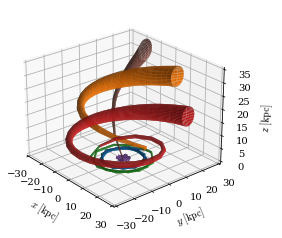

In [19]:
fig = pl.figure()
ax = pl.axes(projection='3d')
_arr = [(a,b) for a,b in enumerate(theta_midbins)]
for i,ind in (_arr[2],_arr[3],_arr[0]):
#     if i==1: continue
    med_ind = int(np.median(tSF_ind[theta_inds[i]]))
    med_dphis, med_Rs, med_zs, med_Ts, med_rhovs = [
        np.nanmedian(val[:,theta_inds[i]],axis=1)[med_ind:] for val in (dphis,Rs,zs,Ts,(nHs*v_abs)**-1)]        
    med_rhovs /= med_rhovs[-1]    
    med_rhovs[med_rhovs<0.1] = 0.1
    for j in range(2)[:]:
        Tinds = (med_Ts<=1e5, med_Ts>1e5)[j]
        if j==0: Tinds[Tinds.nonzero()[0][-1]+1]=True
        plot_helix_pylab(ax,med_dphis[Tinds],med_Rs[Tinds],med_zs[Tinds],med_Ts,med_rhovs[Tinds])
#     ax.scatter3D(_ys[::d],_xs[::d],_zs[::d],label=labels[i],color=colors[i],marker='o',s=2)
    ax.set_ylim(-30,30)
    ax.set_xlim(-30,30)
    ax.set_zlim(0,35)
    ax.view_init(25,-40)
    pl.xlabel(r'$x\ [{\rm kpc}]$')
    pl.ylabel(r'$y\ [{\rm kpc}]$')
    ax.set_zlabel(r'$z\ [{\rm kpc}]$')
#pl.savefig(figdir+'3Dtracks.pdf')

In [20]:
from mayavi import mlab
def plot_helix(ax,_phis,_Rs,_zs,_Ts,_As,a=1):
    _v=pl.linspace(0,2*np.pi,40)
    [phis,v]=np.meshgrid(_phis+np.pi/2,_v)
    [zs,v]=np.meshgrid(_zs,_v)
    [Rs,v]=np.meshgrid(_Rs,_v)
    [Ts,v]=np.meshgrid(_Ts,_v)
    [As,v]=np.meshgrid(_As*a,_v)
    x=(Rs+a*As*np.cos(v))*np.cos(phis)
    y=(Rs+a*As*np.cos(v))*np.sin(phis)
    z=a*As*np.sin(v)+zs
    cc = (log(Ts)-3.5)/3; cc[cc>1] = 1; cc[cc<0] = 0    
    ax.plot_surface(x,y,z,color=c)#,cmap='coolwarm',facecolors=my_col,#(log(Ts)-3.5)/3,
                   #rstride=1, cstride=1, linewidth=0, antialiased=False)#,vmin=3.5,vmax=6.5)


In [21]:
from mayavi import mlab
%gui qt
def plot_helix_mayavi(_phis,_Rs,_zs,_Ts,_As,a=2):
    _v=pl.linspace(0,2*np.pi,40)
    [phis,v]=np.meshgrid(_phis+np.pi/2,_v)
    [zs,v]=np.meshgrid(_zs,_v)
    [Rs,v]=np.meshgrid(_Rs,_v)
    [Ts,v]=np.meshgrid(_Ts,_v)
    [As,v]=np.meshgrid(_As*a,_v)
    x=(Rs+a*As*np.cos(v))*np.cos(phis)
    y=(Rs+a*As*np.cos(v))*np.sin(phis)
    z=a*As*np.sin(v)+zs
    cc = log(Ts); #(log(Ts)-3.5)/3; cc[cc>1] = 1; cc[cc<0] = 0    
    print([_i.shape for _i in (x,y,z,cc)])
#     mlab.points3d(x,y,z,_As*a*2,opacity=0.5,scalars==)
    s = mlab.mesh(x,y,z,opacity=0.5,scalars=cc,colormap='coolwarm',vmin=3.5,vmax=6.5)
#     s.module_manager.scalar_lut_manager.reverse_lut = True
    return s
#     pts = mlab.quiver3d(x, y, z, sx, sy, sz, scalars=cc, opacity=0.5,
#                         mode="sphere", scale_factor=f,colormap='coolwarm')
#     pts.glyph.color_mode = "color_by_scalar"
#     pts.glyph.glyph_source.glyph_source.center = [0,0,0]

In [22]:
_arr = [(a,b) for a,b in enumerate(theta_midbins)]
mlab.figure(bgcolor=(1,1,1), fgcolor=(0.,0.,0.))
for i,ind in (_arr[2],_arr[3],_arr[0]):
    med_ind = int(np.median(tSF_ind[theta_inds[i]]))
    med_dphis, med_Rs, med_zs, med_Ts, med_As = [
        np.nanmedian(val[:,theta_inds[i]],axis=1)[med_ind:] for val in (dphis,Rs,zs,Ts,(nHs*v_abs)**-1)]        
    med_As /= med_As[-1]    
    med_As[med_As<0.03] = 0.03
    print([x.shape for x in (med_dphis, med_Rs, med_zs, med_Ts, med_As)])
    plot_helix_mayavi(med_dphis,med_Rs,med_zs,med_Ts,med_As)
#     mlab.colorbar(title=r'$\log\ T\ [{\rm K}]$',orientation='vertical', label_fmt=r'$%.1f$',nb_labels=7)
ax = mlab.axes(extent=[0,40,0,40,0,40],y_axis_visibility=False,x_axis_visibility=True,z_axis_visibility=False,
             ylabel=r'$R_{\rm cyl}\,[{\rm kpc}]$',nb_labels=0,color=(0,0,0))
oa = mlab.orientation_axes()
oa.axes.x_axis_shaft_property.color = oa.axes.x_axis_tip_property.color = (0.5,0.5,0.5)
oa.axes.y_axis_shaft_property.color = oa.axes.y_axis_tip_property.color = (0.5,0.5,0.5)
oa.axes.z_axis_shaft_property.color = oa.axes.z_axis_tip_property.color = (0.5,0.5,0.5)
pl.savefig(figdir+'3Dtracks_mayavi.pdf')

[(45,), (45,), (45,), (45,), (45,)]
[(40, 45), (40, 45), (40, 45), (40, 45)]
[(45,), (45,), (45,), (45,), (45,)]
[(40, 45), (40, 45), (40, 45), (40, 45)]
[(45,), (45,), (45,), (45,), (45,)]
[(40, 45), (40, 45), (40, 45), (40, 45)]


<Figure size 432x288 with 0 Axes>

/Users/jonathanstern/opt/anaconda3/lib/python3.9/site-packages/tvtk/pyface/ui/qt4/QVTKRenderWindowInteractor.py:381: MatplotlibDeprecationWarning: 
The MathtextBackendBitmap class was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  self._RenderWindow.Render()
Traceback (most recent call last):
  File "/Users/jonathanstern/opt/anaconda3/lib/python3.9/site-packages/pyface/ui/qt4/action/action_item.py", line 379, in _qt4_on_destroyed
    if hasattr(self.control, "_tool_instance"):
RuntimeError: wrapped C/C++ object of type QAction has been deleted
Traceback (most recent call last):
  File "/Users/jonathanstern/opt/anaconda3/lib/python3.9/site-packages/pyface/ui/qt4/action/action_item.py", line 379, in _qt4_on_destroyed
    if hasattr(self.control, "_tool_instance"):
RuntimeError: wrapped C/C++ object of type QAction has been deleted
Traceback (most recent call last):
  File "/Users/jonathanstern/opt/anaconda3/lib/python3.9/s

In [22]:
_arr = [(a,b) for a,b in enumerate(theta_midbins)]
for i,ind in (_arr[2],_arr[3],_arr[0]):
    med_ind = int(np.median(tSF_ind[theta_inds[i]]))
    med_dphis, med_Rs, med_zs, med_Ts, med_As = [
        np.nanmedian(val[:,theta_inds[i]],axis=1)[med_ind:] for val in (dphis,Rs,zs,Ts,(nHs*v_abs)**-1)]        
    med_As /= med_As[-1]    
    print(med_As.min())
    med_As[med_As<0.03] = 0.03
    print([x.shape for x in (med_dphis, med_Rs, med_zs, med_Ts, med_As)])


0.00011222532292053726
[(45,), (45,), (45,), (45,), (45,)]
0.00018401792244139467
[(45,), (45,), (45,), (45,), (45,)]
6.619618346608959e-06
[(45,), (45,), (45,), (45,), (45,)]
